## Visualizations 

Index(['Job titiles', 'AI Impact', 'Tasks', 'AI models', 'AI_Workload_Ratio',
       'Domain'],
      dtype='object')


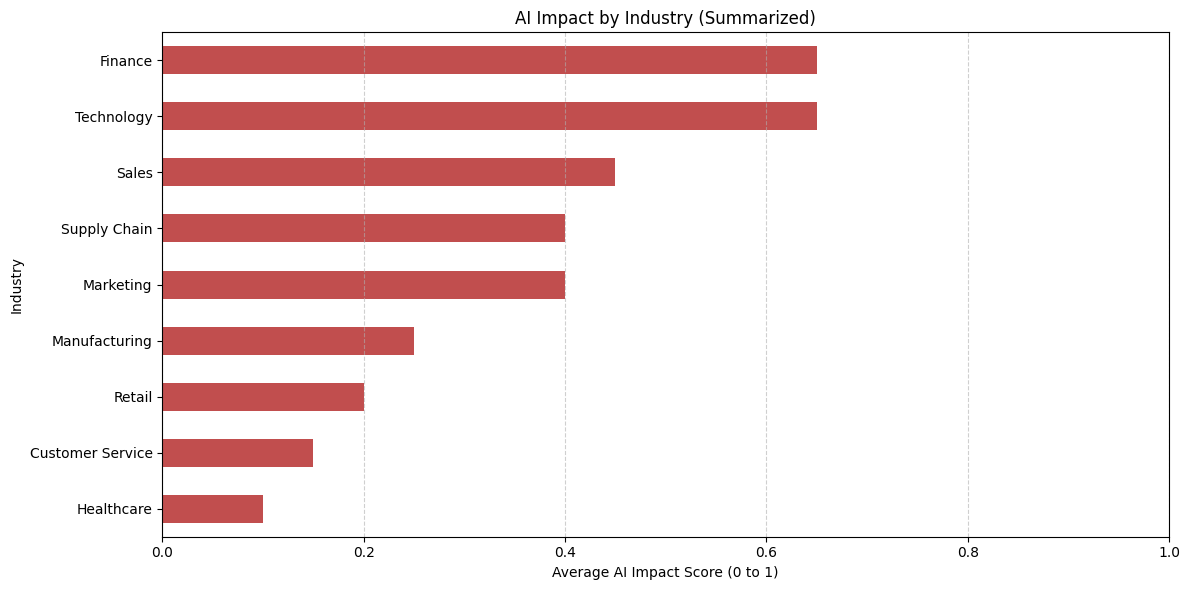

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#  LOAD DATA 
ai_risk_df = pd.read_csv("Ai_risk.csv")
 
#  CHECK FOR JOB TITLE COLUMN 
print(ai_risk_df.columns)
job_column = "Job_Title" if "Job_Title" in ai_risk_df.columns else ai_risk_df.columns[0] 

#  CONVERT AI IMPACT FROM PERCENTAGE TO NUMERIC SCORE 
ai_risk_df["AI_Impact_Score"] = (
    ai_risk_df["AI Impact"]
    .astype(str)
    .str.replace('%', '', regex=True)
    .astype(float) / 100  
)

#  REMOVE MISSING VALUES 
ai_risk_df = ai_risk_df.dropna(subset=["AI_Impact_Score"])

#  GROUP JOBS INTO GENERAL INDUSTRY CATEGORIES 
industry_mapping = {
    "Software Engineer": "Technology",
    "Data Scientist": "Technology",
    "IT Support": "Technology",
    "Marketing Analyst": "Marketing",
    "Financial Analyst": "Finance",
    "Accountant": "Finance",
    "HR Manager": "Human Resources",
    "Sales Representative": "Sales",
    "Factory Worker": "Manufacturing",
    "Retail Associate": "Retail",
    "Medical Assistant": "Healthcare",
    "Nurse": "Healthcare",
    "Logistics Coordinator": "Supply Chain",
    "Warehouse Manager": "Supply Chain",
    "Customer Service Representative": "Customer Service",
   
}

#  mapping to categorize industries
ai_risk_df["General_Industry"] = ai_risk_df[job_column].map(industry_mapping)

# Remove rows where General Industry is still NaN 
ai_risk_df = ai_risk_df.dropna(subset=["General_Industry"])

#  GET AVERAGE AI IMPACT PER GENERAL INDUSTRY 
avg_impact = (
    ai_risk_df.groupby("General_Industry")["AI_Impact_Score"]
    .mean()
    .sort_values(ascending=False)
)

#  PLOT DATA 
plt.figure(figsize=(12, 6))
avg_impact.plot(kind="barh", color="firebrick", alpha=0.8)
plt.title("AI Impact by Industry (Summarized)")
plt.xlabel("Average AI Impact Score (0 to 1)")
plt.ylabel("Industry")
plt.xlim(0, 1)  # should be between 0 and 1
plt.gca().invert_yaxis()  # Flip order for better readability
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()

# PNG FILE  
# plt.savefig("Summarized_AI_Impact_by_Industry.png", dpi=300, bbox_inches="tight")  # Saves as PNG
# plt.show()


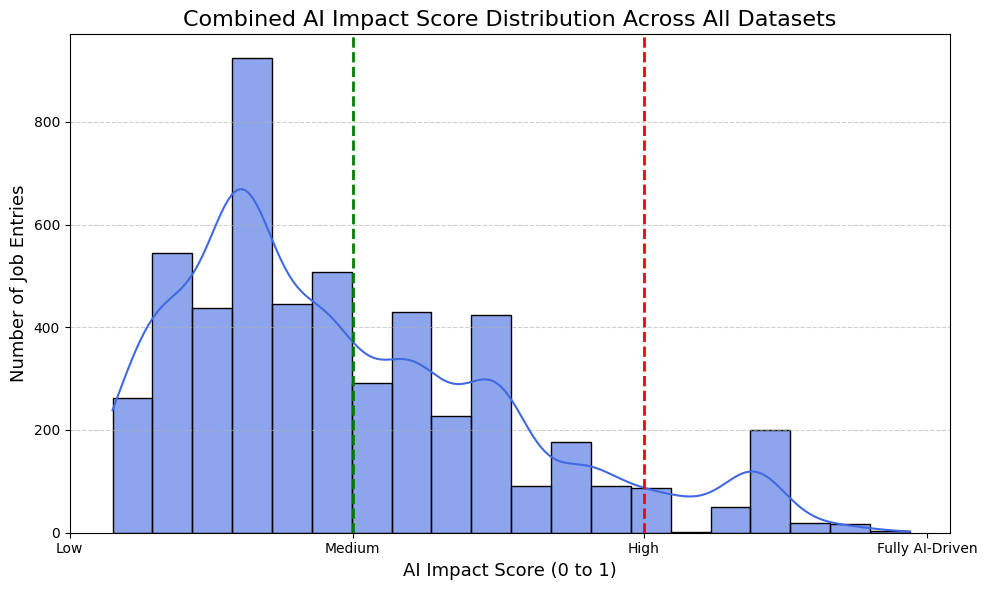

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ai_risk_df = pd.read_csv("Ai_risk.csv")
job_market_df = pd.read_csv("Cleaned_ai_job_market_insights.csv")
ai_adoption_df = pd.read_csv("Cleaned_Analysis_AIAdoption_AutomationRisk.csv")

# Convert percentage column to numeric score
ai_risk_df["AI_Impact_Score"] = ai_risk_df["AI Impact"].astype(str).str.replace('%', '', regex=True).astype(float) / 100

# Map textual levels to scores
level_map = {
    "Low": 0.2,
    "Medium": 0.5,
    "High": 0.8,
    "Very High": 0.95
}

job_market_df["AI_Impact_Score"] = job_market_df["AI_Adoption_Level"].map(level_map)
ai_adoption_df["AI_Impact_Score"] = ai_adoption_df["AI Adoption Level"].map(level_map)

# Merge & clean
impact_scores = pd.concat([
    ai_risk_df["AI_Impact_Score"],
    job_market_df["AI_Impact_Score"],
    ai_adoption_df["AI_Impact_Score"]
], ignore_index=True).dropna()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(impact_scores, bins=20, kde=True, color="royalblue", alpha=0.6)
plt.title("Combined AI Impact Score Distribution Across All Datasets", fontsize=16)
plt.xlabel("AI Impact Score (0 to 1)", fontsize=13)
plt.ylabel("Number of Job Entries", fontsize=13)
plt.xticks([0, 0.33, 0.67, 1], ["Low", "Medium", "High", "Fully AI-Driven"])
plt.axvline(0.33, color="green", linestyle="--", linewidth=2)
plt.axvline(0.67, color="red", linestyle="--", linewidth=2)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Code(DT and RF)

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#  LOAD DATA 
ai_risk_df = pd.read_csv("Ai_risk.csv")
job_market_df = pd.read_csv("Cleaned_ai_job_market_insights.csv")
ai_adoption_df = pd.read_csv("Cleaned_Analysis_AIAdoption_AutomationRisk.csv")

# CLEAN & MERGE 
ai_risk_df.rename(columns={"Job titiles": "Job_Title", "Domain": "Industry"}, inplace=True)
merged_df = ai_risk_df.merge(job_market_df, on=["Industry", "Job_Title"], how="left")\
                      .merge(ai_adoption_df, on=["Industry", "Job_Title"], how="left")
merged_df_cleaned = merged_df.dropna(axis=1, how="all")

merged_df_cleaned["AI_Impact_Percentage"] = merged_df_cleaned["AI models"] / merged_df_cleaned["Tasks"]
merged_df_cleaned["Industry_Risk_Level"] = merged_df_cleaned["Industry"].map({
    "Service Operations": 1, "Supply Chain": 1, "Finance": 0, "IT": -1, "Marketing": -1, "Manufacturing": 0
}).fillna(0)
le = LabelEncoder()
merged_df_cleaned["AI_Impact_Label"] = le.fit_transform(merged_df_cleaned["AI Impact"])

#  REMOVE RARE CLASSES (< 5 samples) 
label_counts = merged_df_cleaned["AI_Impact_Label"].value_counts()
valid_labels = label_counts[label_counts >= 5].index
merged_df_cleaned = merged_df_cleaned[merged_df_cleaned["AI_Impact_Label"].isin(valid_labels)]

#  CLEAN INVALID VALUES 
merged_df_cleaned["AI_Impact_Percentage"].replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df_cleaned["AI_Impact_Percentage"].fillna(merged_df_cleaned["AI_Impact_Percentage"].median(), inplace=True)
merged_df_cleaned["AI_Workload_Ratio"].fillna(merged_df_cleaned["AI_Workload_Ratio"].median(), inplace=True)

X = merged_df_cleaned[["Tasks", "AI models", "AI_Workload_Ratio", "AI_Impact_Percentage", "Industry_Risk_Level"]]
y = merged_df_cleaned["AI_Impact_Label"]

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

#  SCALE AND SPLIT 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#  MODEL TUNING 
dt_params = {"max_depth": [5, 10, 20, None], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4]}
rf_params = {"n_estimators": [100, 200], "max_depth": [5, 10, 20, None], "min_samples_split": [2, 5, 10]}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    dt_params, cv=3, scoring="accuracy", n_jobs=-1
)
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    rf_params, cv=3, scoring="accuracy", n_jobs=-1
)

dt_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)

#  RESULTS 
dt_best = dt_grid.best_estimator_
rf_best = rf_grid.best_estimator_

dt_acc = accuracy_score(y_test, dt_best.predict(X_test))
rf_acc = accuracy_score(y_test, rf_best.predict(X_test))

print(" Decision Tree")
print("Best Params:", dt_grid.best_params_)
print("Accuracy:", round(dt_acc * 100, 2), "%")
print("Feature Importances:", dict(zip(X.columns, dt_best.feature_importances_)))

print("\nRandom Forest ")
print("Best Params:", rf_grid.best_params_)
print("Accuracy:", round(rf_acc * 100, 2), "%")
print("Feature Importances:", dict(zip(X.columns, rf_best.feature_importances_)))


/tmp/ipykernel_1553/804385844.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned["AI_Impact_Percentage"] = merged_df_cleaned["AI models"] / merged_df_cleaned["Tasks"]
/tmp/ipykernel_1553/804385844.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned["Industry_Risk_Level"] = merged_df_cleaned["Industry"].map({
/tmp/ipykernel_1553/804385844.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

 Decision Tree
Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 35.18 %
Feature Importances: {'Tasks': np.float64(0.2325627968669494), 'AI models': np.float64(0.3156546009868714), 'AI_Workload_Ratio': np.float64(0.1970169294061759), 'AI_Impact_Percentage': np.float64(0.25476567274000333), 'Industry_Risk_Level': np.float64(0.0)}

Random Forest 
Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 40.83 %
Feature Importances: {'Tasks': np.float64(0.24648275048025112), 'AI models': np.float64(0.26687994036303464), 'AI_Workload_Ratio': np.float64(0.24644991931874966), 'AI_Impact_Percentage': np.float64(0.2401873898379645), 'Industry_Risk_Level': np.float64(0.0)}


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:02:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 40.39 %
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.48      0.46       102
           1       0.50      0.27      0.35        11
           2       0.30      0.43      0.36        69
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         4
           5       0.39      0.43      0.41       133
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         1
           8       0.46      0.41      0.43        87
           9       0.00      0.00      0.00         3
          10       0.35      0.44      0.39        88
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.37      0.34      0.35        56
          14       0.50      0.33      0.40         3
          15       0.49      0.56      0.52        87
          16       0.00      0.

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.loca

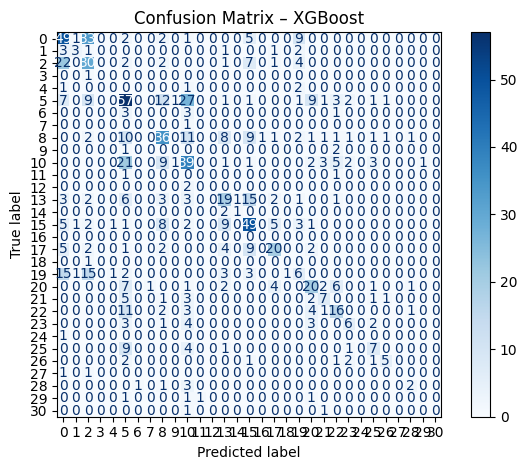

In [6]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Label encode-y variable 
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split using encoded labels
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_preds = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)

print("XGBoost Accuracy:", round(xgb_acc * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test, xgb_preds))

# Confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – XGBoost")
plt.tight_layout()
plt.show()


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:33:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost Accuracy (Balanced): 99.83 %

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       593
           1       1.00      1.00      1.00       549
           2       1.00      1.00      1.00       623

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



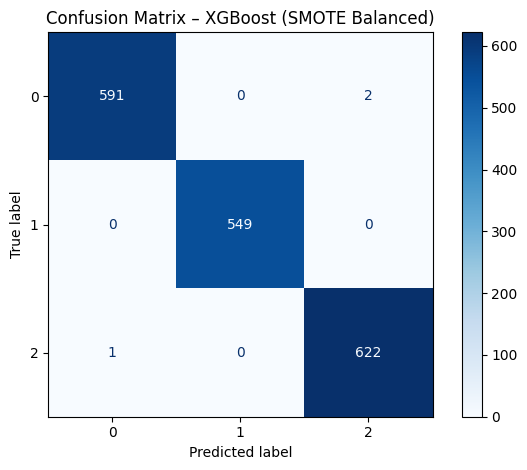

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split balanced data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_preds = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)

print("✅ XGBoost Accuracy (Balanced):", round(xgb_acc * 100, 2), "%")
print("\n📊 Classification Report:\n", classification_report(y_test, xgb_preds))

# Confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – XGBoost (SMOTE Balanced)")
plt.tight_layout()
plt.show()


